Adrian Gruszczynski / Yann Salimi

In [1]:
import os
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

# Implementation of PCA

In [2]:
class PCA:
    """Principal component analysis (PCA).

    :argument n_components: Number of principal components.
    """

    def __init__(self, n_components: int):
        self.n_components = n_components

    def reduce(self, x):
        """Reduce x to `self.n_components` dimensions.

        :param x: array-like matrices of shape (M, N)
        :return: numpy.array of shape(M, `self.n_components`)
        """
        U, S, V = self._decompose(x)
        return U[:, :self.n_components] * S[:self.n_components]

    def components(self, x):
        """Get first `self.n_components` components ordered by variance.

        :param x: array-like matrices of shape (M, N)
        :return: numpy.array of shape (`self.n_components`, N)
        """
        _U, _S, V = self._decompose(x)
        return V[:self.n_components]

    def _decompose(self, x):
        """Singular value decomposition of normalized X.

        :param x: array-like matrices of shape (M, N)
        :return:
            U : numpy.array of shape (M, min(M, N)), unitary matrices
            S : numpy.array of shape (min(M, N)), singular values
            V : numpy.array of shape (min(M, N), N), unitary matrices
        """
        return np.linalg.svd(self._normalize(x), full_matrices=False)

    @staticmethod
    def _normalize(x):
        """Normalizes x by centering around the mean.

        :param x: array-like matrices of shape (M, N)
        :return: numpy.array of shape (M, N)
        """
        return x - np.mean(x, axis=0)

## Reduce the "ZIP-code"-dataset to two dimensions and plot the point cloud of each class

In [3]:
train = np.loadtxt('zip.train')
train_labels, train_features = train[:, 0].astype(int), train[:, 1:]

In [4]:
pca = PCA(2)
reduced = pca.reduce(train_features)
print('Shape before reducing: {}'.format(train_features.shape))
print('Shape after reducing:  {}'.format(reduced.shape))

Shape before reducing: (7291, 256)
Shape after reducing:  (7291, 2)


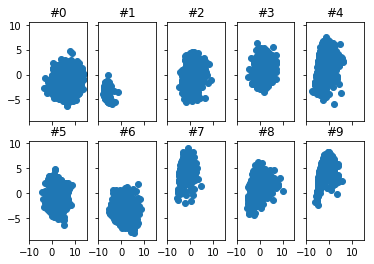

In [5]:
fig, axs = plt.subplots(2, 5, sharex='all', sharey='all')
for i, ax in enumerate(axs.flat):
    x = np.array([p for p, l in zip(reduced, train_labels) if l == i])
    ax.set_title('#{}'.format(i))
    ax.scatter(x[:, 0], x[:, 1])

## Try one of the previously implemented classifiers (k-NN or Least Squares) on the two-dimensional dataset

In [6]:
class NearestNeighbors:
    def __init__(self, train_labels: np.array, train_features: np.array, k_neighbors: int):
        self.train_labels = train_labels
        self.train_features = train_features
        self.k_neighbors = k_neighbors

    def fit(self, features):
        return np.argmax(sum([self.base(self.train_labels[y]) for y in self._nearest_neighbors(features)]))

    def _nearest_neighbors(self, f):
        return np.argpartition([self.dist(tf, f) for tf in self.train_features], self.k_neighbors)[:self.k_neighbors]

    @staticmethod
    def base(j):
        return np.eye(1, 10, j)

    @staticmethod
    def dist(a, b):
        return np.linalg.norm(a - b)

In [7]:
class Assessment:
    def __init__(self, correct, predicted):
        self.correct = correct
        self.predicted = predicted
        self.map = {v: k for k, v in enumerate(sorted(set().union(correct, predicted)))}

    def confusion_matrix(self):
        c = np.zeros(2 * [len(self.map)], dtype=int)
        for correct, predicted in zip(self.correct, self.predicted):
            c[self.map[correct], self.map[predicted]] += 1
        return c

    def accuracy(self):
        return np.mean(self.correct == self.predicted)

In [8]:
test = np.loadtxt('zip.test')
test_labels, test_features = test[:, 0].astype(int), test[:, 1:]

With the full dimensionality and 3-NN:

In [9]:
nn = NearestNeighbors(train_labels, train_features, 3)
predicted = [nn.fit(f) for f in test_features]
assess = Assessment(test_labels, predicted)
print('confusion matrix:\n{}\n'.format(assess.confusion_matrix()))
print('accuracy:\n{}'.format(assess.accuracy()))

confusion matrix:
[[355   0   3   0   0   0   0   0   0   1]
 [  0 258   0   0   3   0   2   1   0   0]
 [  8   0 183   1   1   0   0   2   3   0]
 [  3   0   2 153   0   6   0   1   0   1]
 [  0   2   0   0 183   2   2   2   1   8]
 [  5   0   3   3   0 144   0   0   1   4]
 [  3   1   1   0   2   0 163   0   0   0]
 [  0   1   1   1   4   0   0 138   1   1]
 [  4   0   3   4   0   1   0   1 151   2]
 [  2   0   0   0   3   0   0   4   0 168]]

accuracy:
0.9446935724962631


Reduced to 2d by PCA and 3-NN:

In [10]:
train_reduced = pca.reduce(train_features)
test_reduced = pca.reduce(test_features)
nn_reduced = NearestNeighbors(train_labels, train_reduced, 3)
predicted_reduced = [nn_reduced.fit(f) for f in test_reduced]
assess_reduced = Assessment(test_labels, predicted_reduced)
print('confusion matrix:\n{}\n'.format(assess_reduced.confusion_matrix()))
print('accuracy:\n{}'.format(assess_reduced.accuracy()))

confusion matrix:
[[  2 221  33   6  41   3   8  23  13   9]
 [244   0   0   1   2   2  15   0   0   0]
 [ 31   2  62  26  27  15  15   3   9   8]
 [ 13   1  40  32  31   4   0  17  17  11]
 [ 28   1  34  68  31  12   3   8   4  11]
 [ 11  15  46  15  27   8  11   5  14   8]
 [ 17  13  33   3   8  10  81   0   4   1]
 [  7   0  10  47  22   1   0  17   5  38]
 [ 30   1  37  32  20  12   1  12  13   8]
 [ 17   0  21  60  27   5   0  11   9  27]]

accuracy:
0.13602391629297458


# Eigenfaces

In [11]:
face_files = {}
for face_file in os.listdir('lfwcrop_grey/faces'):
    name = re.search(r'(.+)_\d', face_file).group(1)
    if name in face_files.keys():
        face_files[name].append('lfwcrop_grey/faces/' + face_file)
    else:
        face_files[name] = ['lfwcrop_grey/faces/' + face_file]

In [12]:
faces = [plt.imread(f) for name, files in face_files.items() for f in files]
faces_flat = np.array([np.array(f).flatten() for f in faces])

In [13]:
assert len(set(len(f) for f in faces_flat)) == 1

In [14]:
pca = PCA(10)
components = pca.components(faces_flat)

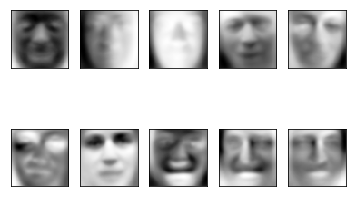

In [15]:
fig, axs = plt.subplots(2, 5, subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axs.flat):
    ax.imshow(components[i].reshape(64, 64), cmap='Greys')